In [1]:
greetings = "Assalam-o-Alaikum!"
print(greetings)

Assalam-o-Alaikum!


### Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import re

### Document Clustering

In [4]:
df = pd.read_csv("movies_plot.csv")
df[:3]

,Title,Plot
0,The Ballad of Cable Hogue,"Cable Hogue is isolated in the desert, awaitin..."
1,Monsters vs. Aliens,"In the far reaches of space, a planet explodes..."
2,The Bandit Queen,Zarra Montalvo is the daughter of an American ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   1000 non-null   object
 1   Plot    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


### Function to Remove Noise

In [6]:
def remove_noise(text, stop_words = []):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

### Initialize TfidfVectorizer

In [7]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.75, max_features=50, tokenizer=remove_noise)

# Use the .fit_transform() on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Plot"])

### Generate Top 3 Terms from 2 Clusters

In [8]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['her', 'she', 'him']
['him', 'they', 'who']


### Import Fifa Dataset

In [9]:
fifa = pd.read_csv('fifa_18_sample_data.csv')
fifa[:3]

,ID,name,full_name,club,club_logo,special,age,league,birth_date,height_cm,...,prefers_cb,prefers_lb,prefers_lwb,prefers_ls,prefers_lf,prefers_lam,prefers_lcm,prefers_ldm,prefers_lcb,prefers_gk
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,https://cdn.sofifa.org/18/teams/243.png,2228,32,Spanish Primera División,1985-02-05,185.0,...,False,False,False,False,False,False,False,False,False,False
1,158023,L. Messi,Lionel Messi,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2158,30,Spanish Primera División,1987-06-24,170.0,...,False,False,False,False,False,False,False,False,False,False
2,190871,Neymar,Neymar da Silva Santos Jr.,Paris Saint-Germain,https://cdn.sofifa.org/18/teams/73.png,2100,25,French Ligue 1,1992-02-05,175.0,...,False,False,False,False,False,False,False,False,False,False


### Select 3 Features and Normalize Them

In [10]:
fifa['scaled_pac'] = whiten(fifa['pac'])
fifa['scaled_dri'] = whiten(fifa['dri'])
fifa['scaled_sho'] = whiten(fifa['sho'])

### Create Clusters and Assign Labels

In [11]:
cluster_centers, _ = kmeans(fifa[['scaled_pac', 'scaled_dri', 'scaled_sho']], 3)

fifa['cluster_labels'], _ = vq(fifa[['scaled_pac', 'scaled_dri', 'scaled_sho']], cluster_centers)

### Print the size of the clusters

In [12]:
fifa.groupby('cluster_labels')['ID'].count()

cluster_labels
0    181
1    335
2    484
Name: ID, dtype: int64

### Print the mean value of wages in each cluster

In [13]:
print(fifa.groupby('cluster_labels')['eur_wage'].mean())

cluster_labels
0    62193.370166
1    64128.358209
2    75809.917355
Name: eur_wage, dtype: float64


**The overall level of a player in FIFA 18 is defined by six characteristics: pace (pac), shooting (sho), passing (pas), dribbling (dri), defending (def), physical (phy)**

In [14]:
fifa['scaled_def'] = whiten(fifa['def'])
fifa['scaled_phy'] = whiten(fifa['phy'])

### Select All Scaled Features

In [15]:
scaled_features = ['scaled_pac', 'scaled_sho', 'scaled_pac', 'scaled_dri', 'scaled_def', 'scaled_phy']

In [16]:
# Create centroids with kmeans for 2 clusters
cluster_centers, _ = kmeans(fifa[scaled_features], 2)

# Assign cluster labels and print cluster centers
fifa['cluster_labels'], _ = vq(fifa[scaled_features], cluster_centers)
fcl = fifa.groupby('cluster_labels')[scaled_features].mean().reset_index()
fcl

,cluster_labels,scaled_pac,scaled_sho,scaled_pac,scaled_dri,scaled_def,scaled_phy
0,0,6.818301,5.466720,6.818301,8.568907,2.390061,8.286152
1,1,5.463794,3.964297,5.463794,7.027752,3.865909,9.117086


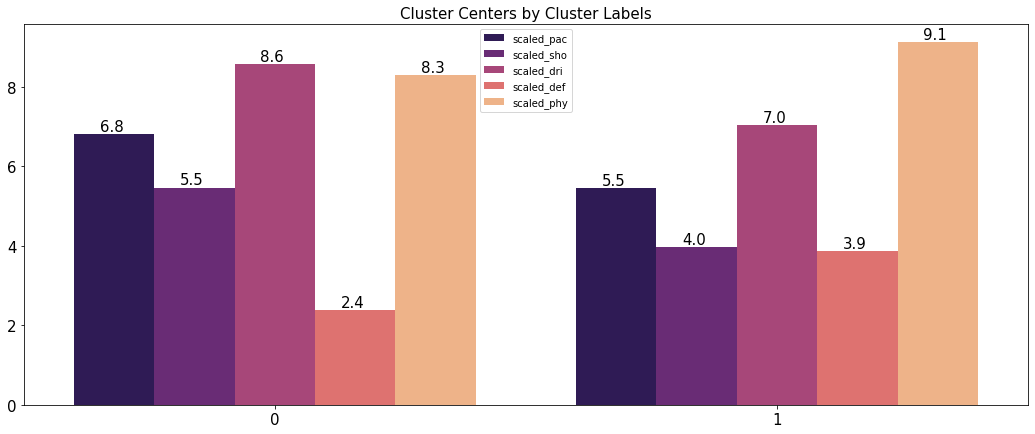

In [17]:
# Plot cluster centers to visualize clusters
fclm = fcl.melt("cluster_labels", var_name = "Scaled Features", value_name = "Mean")

plt.figure(figsize = (18, 7))
graph = sns.barplot(x = "cluster_labels", y = "Mean", hue = "Scaled Features", data = fclm, palette = "magma")
for p in graph.patches:
        graph.annotate('{:.01f}'.format(p.get_height()), 
                      (p.get_x()+0.075, p.get_height()),
                       ha='center', va='bottom',color= 'black', size = 15)
plt.title("Cluster Centers by Cluster Labels", size = 15)
plt.legend(loc = 9)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [18]:
# Get the name column of first 5 players in each cluster
for cluster in fifa['cluster_labels'].unique():
    print(cluster, fifa[fifa['cluster_labels'] == cluster]['name'].values[:5])

0 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
1 ['T. Kroos' 'Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng']
